In [1]:
#installing dependencies
!pip install -q kaggle
!pip install numpy==1.15.0

    100% |████████████████████████████████| 13.9MB 2.6MB/s 
torchvision 0.2.1 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
thinc 6.12.1 has requirement wrapt<1.11.0,>=1.10.0, but you'll have wrapt 1.11.1 which is incompatible.
pymc3 3.6 has requirement joblib<0.13.0, but you'll have joblib 0.13.2 which is incompatible.
featuretools 0.4.1 has requirement pandas>=0.23.0, but you'll have pandas 0.22.0 which is incompatible.
albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.8 which is incompatible.
  Found existing installation: numpy 1.14.6
    Uninstalling numpy-1.14.6:
      Successfully uninstalled numpy-1.14.6


In [1]:
!pip install catboost

    100% |████████████████████████████████| 55.5MB 560kB/s 
    100% |████████████████████████████████| 55.5MB 560kB/s 


In [0]:
#import required libraries
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor,Pool
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import NuSVR, SVR
from sklearn.kernel_ridge import KernelRidge
import matplotlib.pyplot as plt


In [4]:
#reading the .json file from kaggle to read data
from google.colab import files
uploaded=files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 66 bytes


In [5]:
#getting kaggle competitions list
!kaggle competitions list

ref                                            deadline             category            reward  teamCount  userHasEntered  
---------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
digit-recognizer                               2030-01-01 00:00:00  Getting Started  Knowledge       2518           False  
titanic                                        2030-01-01 00:00:00  Getting Started  Knowledge      10183           False  
house-prices-advanced-regression-techniques    2030-01-01 00:00:00  Getting Started  Knowledge       4145           False  
imagenet-object-localization-challenge         2029-12-31 07:00:00  Research         Knowledge         35           False  
competitive-data-science-predict-future-sales  2019-12-31 23:59:00  Playground           Kudos       2417           False  
two-sigma-financial-news                       2019-07-15 23:59:00  Featured          $100,000       2927           False  
LANL-Ear

In [6]:
#downloading data
!kaggle competitions download -c LANL-Earthquake-Prediction

  0% 0.00/33.3k [00:00<?, ?B/s]
100% 33.3k/33.3k [00:00<00:00, 29.7MB/s]
 92% 222M/242M [00:01<00:00, 132MB/s]
100% 242M/242M [00:01<00:00, 152MB/s]
100% 2.02G/2.03G [00:37<00:00, 30.4MB/s]
100% 2.03G/2.03G [00:37<00:00, 57.9MB/s]


In [7]:
!ls

sample_data  sample_submission.csv  test.zip  train.csv.zip


In [8]:
!unzip train.csv.zip

Archive:  train.csv.zip
  inflating: train.csv               


In [9]:
!ls

sample_data  sample_submission.csv  test.zip  train.csv  train.csv.zip


In [0]:
training_data=pd.read_csv('train.csv',nrows=7000000,dtype={'acoustic_data':np.int16,'time_to_failure':np.float64})

In [11]:
training_data.head(10)

,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691
5,8,1.4691
6,9,1.4691
7,7,1.4691
8,-5,1.4691
9,3,1.4691


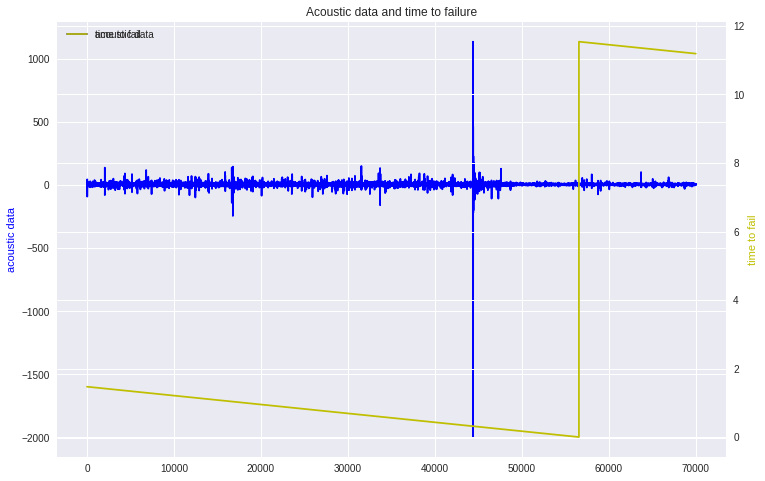

In [23]:
#EDA
train_sample_df=training_data['acoustic_data'].values[::100]
train_timetofail_sample=training_data['time_to_failure'].values[::100]

def plot_acc_data(train_sample,train_timetofail_sample,title='Acoustic data and time to failure'):
  fig,ax=plt.subplots(figsize=(12,8))
  plt.title(title)
  plt.plot(train_sample,color='b')
  ax.set_ylabel('acoustic data', color='b')
  plt.legend(['acoustic data'],loc=(0.01,0.95))
  ax1=ax.twinx()
  plt.plot(train_timetofail_sample, color='y')
  ax1.set_ylabel('time to fail',color='y')
  plt.legend(['time to fail'],loc=(0.01,0.95))
  plt.grid(True)
plot_acc_data(train_sample_df,train_timetofail_sample)
del train_sample_df
del train_timetofail_sample

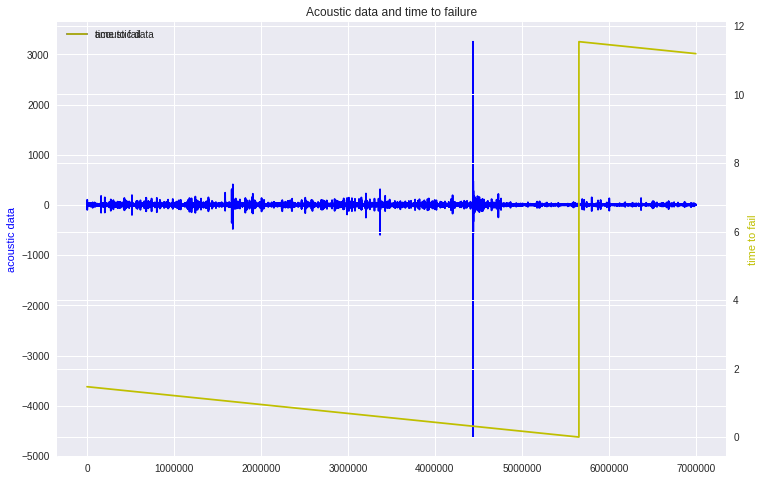

In [24]:
plot_acc_data(training_data['acoustic_data'],training_data['time_to_failure'])

In [0]:
#Feature Engineering- Generating features
def generate_features(X):
  strain=[]
  strain.append(X.mean())
  strain.append(X.std())
  strain.append(X.min())
  strain.append(X.max())
  strain.append(X.kurtosis())
  strain.append(X.skew())
  strain.append(np.quantile(X,0.01))
  strain.append(np.quantile(X,0.05))
  strain.append(np.quantile(X,0.95))
  strain.append(np.quantile(X,0.99))
  strain.append(np.abs(X).max())
  strain.append(np.abs(X).mean())
  strain.append(np.abs(X).std())
  return pd.Series(strain)

In [0]:
train=pd.read_csv('train.csv',iterator=True,chunksize=150_000,dtype={'acoustic_data':np.int16,'time_to_failure':np.float64})
x_train=pd.DataFrame()
y_train=pd.Series()

for df in train:
  ch=generate_features(df['acoustic_data'])
  x_train=x_train.append(ch,ignore_index=True)
  y_train=y_train.append(pd.Series(df['time_to_failure'].values[-1]))

In [31]:
x_train.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12
count,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000
mean,4.519475,6.547788,-149.190942,163.522288,68.297997,0.125830,-11.224603,-2.184779,11.231716,20.321890,170.046246,5.547367,5.750165
std,0.256049,8.503939,265.087984,272.930331,70.532565,0.477901,14.106852,2.346558,2.358067,14.225526,296.887015,1.517038,8.339211
min,3.596313,2.802720,-5515.000000,23.000000,0.648602,-4.091826,-336.000000,-39.000000,9.000000,11.000000,23.000000,4.147707,2.589085
25%,4.349497,4.478637,-154.000000,92.000000,28.090227,-0.040779,-14.000000,-3.000000,10.000000,15.000000,94.000000,5.061843,3.862810
50%,4.522147,5.618798,-111.000000,123.000000,45.816625,0.085620,-10.000000,-2.000000,11.000000,19.000000,127.000000,5.380853,4.781513
75%,4.693350,6.880904,-79.000000,170.000000,78.664202,0.253930,-6.000000,-1.000000,12.000000,23.000000,175.000000,5.748553,5.887947
max,5.391993,153.703569,-15.000000,5444.000000,631.158927,4.219429,-2.000000,0.000000,50.000000,337.000000,5515.000000,32.762073,150.432368


In [35]:
#Model CatBoost
training_pool=Pool(x_train,y_train)
m=CatBoostRegressor(iterations=10000,loss_function='MAE',boosting_type='Ordered')
m.fit(x_train,y_train,silent=True)
m.best_score_

{'learn': {'MAE': 1.7804224713035586}}

In [37]:
#SVM Model + GridSearch
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import NuSVR, SVR

scaler=StandardScaler()
scaler.fit(x_train)
x_train_scaled=scaler.transform(x_train)

parameters=[{'gamma':[0.001,0.005,0.01,0.02,0.05,0.1],'C':[0.1,0.2,0.25,0.5,1,1.5,2]}]

reg=GridSearchCV(SVR(kernel='rbf',tol=0.01),parameters,cv=5,scoring='neg_mean_absolute_error')
reg.fit(x_train_scaled,y_train.values.flatten())
y_pred=reg.predict(x_train_scaled)

print('Best CV Score: {:.4f}'.format(reg.best_score_))
print(reg.best_params_)

Best CV Score: -2.1722
{'C': 2, 'gamma': 0.02}
